In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, activations
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

In [2]:
train_df = pd.read_csv('../data/train_1Dx.csv',nrows=1000000)
test_df = pd.read_csv('../data/test_1Dx.csv',nrows=500000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [5]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [6]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = 0.1+tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [7]:
baseline_model = keras.models.load_model("./trained_models/keras_cnn_unquantized.h5",
                                        custom_objects = {
                                            "custom_loss": custom_loss
                                        })

Metal device set to: Apple M1


2022-11-17 12:07:45.044282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 12:07:45.044391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
p_test = baseline_model.predict(X_test)
df = pd.DataFrame(p_test,columns=['predictions','uncertainty'])
df['uncertainty'] = 0.1 + tf.math.softplus(df['uncertainty'])
df['truth'] = y_test
residuals = df["truth"] - df["predictions"]
print(np.mean(residuals), np.std(residuals))

2022-11-17 12:07:45.338426: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-17 12:07:45.368661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


-0.1251449775905361 6.421612183052123


In [9]:
def CreateQModel(shape):
    x = x_in = Input(shape)
    x = QDense(units = 64, 
               kernel_quantizer="quantized_bits(bits = 8,integer = 4,symmetric=1)",
               use_bias= True,
               bias_quantizer= "quantized_bits(bits = 8,integer = 4,symmetric=1)",
               name = "dense1")(x)
    x = QActivation(activation="quantized_relu(bits = 8, integer = 4, use_sigmoid = 1)", 
                    name="relu1")(x)
    x = BatchNormalization()(x)
    x = QDense(units = 2,
               kernel_quantizer="quantized_bits(bits = 8,integer = 4,symmetric=1)", 
               use_bias= True,
               bias_quantizer= "quantized_bits(bits = 8,integer = 4,symmetric=1)",
               name="dense2")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateQModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0025),
              loss=custom_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (QDense)             (None, 64)                1408      
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (QDense)             (None, 2)                 130       
                                                                 
Total params: 1,794
Trainable params: 1,666
Non-trainable params: 128
_________________________________________________________

In [10]:
es = EarlyStopping(patience=10,
                   min_delta = 1e-5)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=1000, 
                    batch_size=2048,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/1000


2022-11-17 12:08:11.680437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - ETA: 0s - loss: 9.5432

2022-11-17 12:08:24.696895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 16s 36ms/step - loss: 9.5432 - val_loss: 5.1116
Epoch 2/1000
391/391 [==============================] - 13s 33ms/step - loss: 4.8631 - val_loss: 4.6895
Epoch 3/1000
391/391 [==============================] - 13s 32ms/step - loss: 4.5221 - val_loss: 4.7759
Epoch 4/1000
391/391 [==============================] - 13s 33ms/step - loss: 4.2785 - val_loss: 4.2308
Epoch 5/1000
391/391 [==============================] - 13s 33ms/step - loss: 4.0916 - val_loss: 4.0877
Epoch 6/1000
391/391 [==============================] - 13s 33ms/step - loss: 3.9299 - val_loss: 4.1717
Epoch 7/1000
391/391 [==============================] - 13s 33ms/step - loss: 3.8404 - val_loss: 3.7969
Epoch 8/1000
391/391 [==============================] - 13s 33ms/step - loss: 3.7940 - val_loss: 4.2126
Epoch 9/1000
391/391 [==============================] - 13s 33ms/step - loss: 3.7433 - val_loss: 3.7871
Epoch 10/1000
391/391 [==============================] - 13s 33ms/step - loss

/var/folders/w1/wy8xldzx1nsdnpwxfmx7lz3w0000gn/T/ipykernel_4358/3849932070.py:13: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


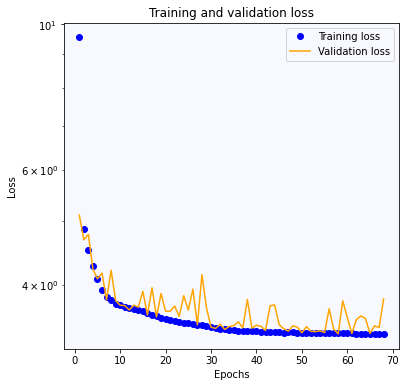

In [11]:
plt.figure(figsize = (6,6))
plt.rcParams['axes.facecolor'] = 'ghostwhite'
# plotting obtained training and test loss
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()


In [12]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['predictions','uncertainty'])
df['uncertainty'] = 0.1 + tf.math.softplus(df['uncertainty'])
df['truth'] = y_test
# df.to_csv("test_1DxGauss.csv",header=False,index=False)

2022-11-17 12:22:50.635207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


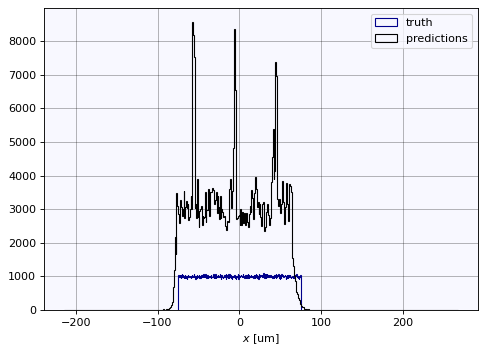

In [13]:
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(df["truth"], bins = 500, color = "darkblue", histtype = "step" )
plt.hist(df["predictions"], bins = 500, color = "black", histtype = "step" )
# plt.xlim([-80,80])
plt.xlabel(r'$x$ [um]')
plt.legend(["truth", "predictions"])
plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

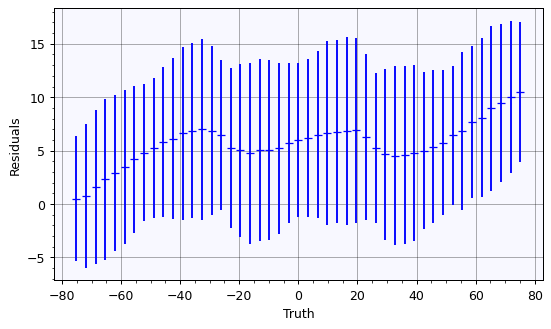

In [14]:
def compute_profile(x, y, nbin=100):
    
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x,y,nbin)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array      = []
    x_slice_mean = []
    x_slice_rms  = []
    for i in range(xe.size-1):
        yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            x_slice_rms.append( yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

plt.figure(figsize = (7,4), dpi= 90)
p_x, p_mean, p_rms = compute_profile(x = df["truth"],
                                     y = df["truth"] - df["predictions"],
                                     nbin = np.linspace(-80,80,50))
plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='blue', color='blue')

plt.xlabel("Truth")
plt.ylabel("Residuals")
# plt.ylim([-2,2])
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

5.6950159595877174 7.861216409129594


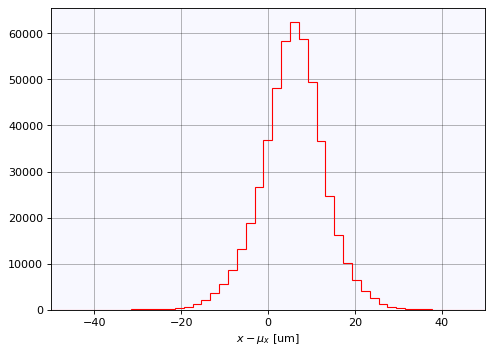

In [15]:
residuals = df["truth"] - df["predictions"]
print(np.mean(residuals), np.std(residuals))
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(residuals, bins = np.linspace(-50,50,50), color = "red", histtype = "step")
plt.xlabel(r'$x-\mu_x$ [um]')
plt.xlim([-50,50])
plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

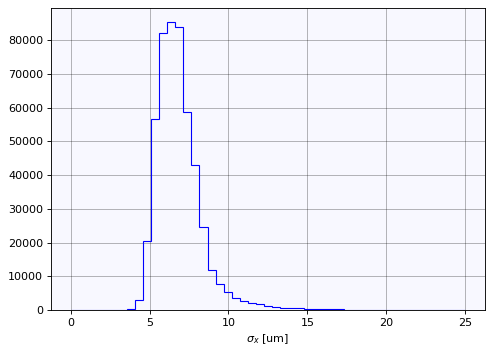

In [16]:
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(df["uncertainty"], bins=np.linspace(0,25,50), color = "blue", histtype = "step")
plt.xlabel(r'$\sigma_x$ [um]')
plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

In [17]:
# model.save("./trained_models/keras_cnn_quantized.h5")